**Рынок заведений общественного питания Москвы**

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Необходимо подготовить исследование рынка на основе открытых данных о заведениях общественного питания в Москве.

## Открытие файла с данными и изучение общей информации

Для того, чтобы начать исследование, необходимо обновить и установить используемые в работе библиотеки:

In [1]:
#обновим библиотеку, чтобы избежать "поломок" визуальзации

In [2]:
pip install -U seaborn --quiet 

You should consider upgrading via the '/Users/esyutkina/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# данная библиотеку была необходима для получения данных из открытых источников (так как данные получены, я ее "затушила")
# pip install -U geocoder --quiet 

In [4]:
# аналогично предыдущей
# pip install -U yandex-geocoder --quiet 

In [5]:
# данная библиотеку необходима для визуализации карт с помощью kepler

In [6]:
pip install -U ipywidgets --quiet 

You should consider upgrading via the '/Users/esyutkina/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
# собственно сам kepler

In [8]:
pip install -U keplergl --quiet 

You should consider upgrading via the '/Users/esyutkina/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
#установим библиотеки, необходимые для исследования
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy import stats as st
import math as mth
import seaborn as sns
from io import BytesIO
import requests
# import geocoder
import warnings
import keplergl

#устраним появляющиеся системные соообщения
warnings.filterwarnings('ignore')

#визуально выведем все колонки в таблице
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [10]:
#прочтем файлы с исходным данными и запишем их в датафрейм
df = pd.read_csv('/Users/esyutkina/Desktop/Практикум/ 8 Исследование ресторанов Москвы/мой проект/rest_data (1).csv')
#посмотрим на исходные данные
display(df.head())
print(df.info())
print(df.describe())

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
None
                  id        number
count   15366.000000  15366.000000
mean   119720.066901     59.547182
std     73036.130732     74.736833
min       838.000000      0.000000
25%     28524.000000     12.000000
50%    144974.500000     40.000000
75%    184262.250000     80.000000
max    223439.000000   1700.000000


Обнаружены нулевые значения в количестве посадочных мест. Посмотрим каким видам объектов характерно отсутствие мест.

In [11]:
# выберем строки с нулевым количеством посадочных мест
df_0 = df.loc[df['number'] == 0]
# выведем виды объектов
print(df_0['object_type'].unique())
#создадим переменную для выбора медианы в зависимости от жилой площади
number_median = df.groupby(['object_type']).agg({'number': 'median'}).reset_index()
display(number_median)

['закусочная' 'предприятие быстрого обслуживания' 'столовая' 'кафетерий'
 'кафе' 'магазин (отдел кулинарии)' 'буфет' 'бар' 'ресторан']


,object_type,number
0,бар,35
1,буфет,32
2,закусочная,0
3,кафе,30
4,кафетерий,6
5,магазин (отдел кулинарии),0
6,предприятие быстрого обслуживания,5
7,ресторан,80
8,столовая,103


Видно, что нулевое количество мест характерно только закусочным и магазина (отделас кулинарии), что вполне логично. Остальные нули являются ошибками при выгрузке данных из открытых источников, поэтому заменим их на медианные значения относительно вида объекта.

In [12]:
#заменим нули в количестве посадочных мест на медианы в зависимости от вида объекта
df.loc[(df['number'] == 0) & (df['object_type'] != 'закусочная') & (df['object_type'] != 'магазин (отдел кулинарии)'), 'number'] = number_median

По исходным данным можно сказать, что визуально пропусков в данных не наблюдается (на основании метода info()). Типы данных логически соответствуют представленным данным. Изучим количество и качество уникальных значений в данных.

In [13]:
# исследуем уникальные значения в названиях типов заведени
print('\nколичество уникальных типов заведений:', df['object_type'].nunique())
print('\nТИПЫ ОБЪЕКТОВ')
for object in df['object_type'].unique():
    print(object)   
print('\nколичество уникальных объктов:', df['id'].nunique())


количество уникальных типов заведений: 9

ТИПЫ ОБЪЕКТОВ
кафе
столовая
закусочная
предприятие быстрого обслуживания
ресторан
кафетерий
буфет
бар
магазин (отдел кулинарии)

количество уникальных объктов: 15366


Все объекты в данных имеют уникальный идентификатор, что значит, что полных дубликатов не имеется. Типы объектов без аномалий.

In [14]:
# исследуем уникальные значения в названиях заведений
print('\nколичество уникальных названий заведений:', df['object_name'].nunique())
print('\nуникальные названия заведений:', df['object_name'].unique())


количество уникальных названий заведений: 10393

уникальные названия заведений: ['СМЕТАНА' 'Родник' 'Кафе «Академия»' ... 'Бар Мята Lounge'
 'Мята Lounge Октябрьская' 'Кальянная «Мята Lounge»']


Уникальных названий заведений 10393 - не исключено, что часть из них уникальны из-за разного написания названий одних и тех же объектов. На постановку вопросов исследования названия объектов не осказывают влияния, поэтому спишем эту ошибку на методологию составления открытых данных.

In [15]:
# исследуем уникальные значения в названиях признака сети
print('\nПРИЗНАК СЕТИ')
for chain in df['chain'].unique():
    print(chain)   


ПРИЗНАК СЕТИ
нет
да


Для дальнейшей визуализации переименуем признак сети.

In [16]:
# создадим функцию для переименования признака сети
def rename_chain(chain):
        if chain == 'да':
            return 'сетевой'   
        else:
            return 'не сетевой'
# применим фунцию       
df['chain'] = df['chain'].apply(rename_chain)

Для дальнейшего исследования нам необходимы дополнительные данные из открытых источников - названия округов, а также координаты. Для того, чтобы получить координаты нам необходимо выбрать все уникальные адреса, создать запрос к внешнему источнику и сохранить полученные данные для дальнейшего использования. Было предпринято несколько попыток получения данных, опишу два более менее успешных из них. Код закомментирован ввиду того, что данные были уже получены. 

In [17]:
## формируем список уникальных адресов
# streets = df['address'].unique()
# streets_un = df.drop_duplicates('address').reset_index()
# un = streets_un['address'].unique()
# un

- первым способом получения данных я выбрала обращение к библиотеке **yandex_geocoder** (https://github.com/sivakov512/yandex-geocoder). Для работы с ней мне необходимо было получить API ключ в кабинете разработчика Яндекс и на бесплатном тарифе создать запросы. Бесплатный тариф включал в себя ограничения (с которыми я познакомилась уже когда мой аккаунт заблокировали) в 1000 запросов. Превысив лимит в 4 раза, мой аккаунт заблокировали. (-_-)

In [18]:
## способ 1 
## устанавливаем необходимые библиотеки 
# from decimal import Decimal
# from yandex_geocoder import Client
## прописываем API
# client = Client('f3263d64-cc49-41d9-b1bb-1f9d90c77443')
## создаем пустой датафрем для дальнейшей записи данных
# df_address = pd.DataFrame(columns=['address','lat','lot'])
## прописываем цикл запроса данных и их записи
# for i in un:
#     coordinates = client.coordinates(i)
#     df_address.loc[i] = [i, coordinates[0], coordinates[1]]
## записываем полученные данные в csv файл
# df_address.to_csv('adress-reserve.csv', index=False) 

 - после проваленной попытки работы с **yandex_geocoder**, я перешла к тестированию библиотеки **geocoder**, а именно начала создавать запрос к **arcgis** (https://geocoder.readthedocs.io/providers/ArcGIS.html). Методика запроса аналогична предыдущему способу, только исключает использование ключа - все те же уникальные адреса я отправляла в запросе и полученные данные писала в файл. Часть нераспознаных адресов была не записана, но 8 тыс. адресов из 9 тыс. были распознаны и получили свои координаты. 

In [19]:
## способ 2 (успешный)
## создаем пустой датафрем для дальнейшей записи данных
# df_address = pd.DataFrame(columns=['address','lat','lot'])
## прописываем цикл запроса данных и их записи
# for i in un:
#     g = geocoder.arcgis(i)
#     df_address.loc[i] = [i, g.latlng[0], g.latlng[1]]
## записываем полученные данные в csv файл
# df_address.to_csv('adress-arcgis.csv', index=False) 

Далее файл с полученными данными я импортировала в Google Sheets и создала соединение в Notebook.

In [20]:
# создаем соединение с Google Sheets
spreadsheet_id = '1i3zM2GUueD7-cvFTWqgmdWhSLaTQiWgpxZLMbYoKTS0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
# записываем данные в датафрейм
df_geo = pd.read_csv(BytesIO(r.content))
# выводим датафрейм
df_geo

,address,lat,lon
0,"город Москва, улица Егора Абакумова, дом 9",55.879030,37.714530
1,"город Москва, улица Талалихина, дом 2/1, корпус 1",55.507320,37.579440
2,"город Москва, Абельмановская улица, дом 6",55.735580,37.669590
3,"город Москва, Абрамцевская улица, дом 1",55.892780,37.573040
4,"город Москва, Абрамцевская улица, дом 9, корпус 1",55.904488,37.574018
...,...,...,...
8028,"Алтуфьевское шоссе, дом 52А",55.878030,37.588560
8029,"город Москва, Хорошёвское шоссе, дом 1",55.773350,37.543950
8030,"город Москва, улица Менжинского, дом 38, корпус 2, строение 2",55.870468,37.660066
8031,"город Москва, Верхняя Красносельская улица, дом 38/19, строение 1",55.779666,37.665406


Данные с координатами были получены. Данные с округами (https://github.com/Distans/temp/blob/main/mosgaz-streets.csv) во избежание удаления файла (в дальнейшем он и правда был удален) были перенесены в Google Sheets. Аналогично предыдущему создано соединение с таблицей.

In [21]:
# создаем соединение с Google Sheets
spreadsheet_id = '1_NLl3XvfhnrSgRN9JUiASkzvhezvHSrmPSkc70gXDWI'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
# записываем данные в датафрейм
df_outer = pd.read_csv(BytesIO(r.content))
# переименуем столбец streetname
df_outer = df_outer.rename(columns={'streetname':'street'}) 
# отберем необходимые стобцы
df_outer = df_outer[['street', 'area']]
# выводим датафрейм
df_outer

,street,area
0,Выставочный переулок,Пресненский район
1,улица Гашека,Пресненский район
2,Большая Никитская улица,Пресненский район
3,Глубокий переулок,Пресненский район
4,Большой Гнездниковский переулок,Пресненский район
...,...,...
4393,Вознесенский проезд,Пресненский район
4394,Волков переулок,Пресненский район
4395,Поварская улица,Пресненский район
4396,Кудринская площадь,Пресненский район


### Вывод

Описание данных:

**1. Датафрейм df (/datasets//rest_data.csv)**

- id — идентификатор объекта;

- object_name — название объекта общественного питания;

- chain — признак сети;

- object_type — тип объекта общественного питания;

- address — адрес;

- number — количество посадочных мест.

**2. Датафрейм df_geo (Google Sheets)**

- address — уникальный адресс;

- lat — широта;

- lon — долгота.

**3. Датафрейм df_outer (Google Sheets)**

- street — улица;

- area — округ, соответсвующий улице.

На данном этапе был проведено исследование количественных и качественных показателей данных - дубликатов и пропусков не обнаружено. Найдены различия в написании названия объектов, но влияния на дальнейший анализ они не имеют. Также произведена замена наименований признака сети для дальнейшей визуализации. Найдены и заменены нулевые значения в количестве посадочных мест. Созданы запросы и подключения к внешним источникам данных.

## Анализ данных

### Исследование соотношения видов объектов общественного питания по количеству объектов.

Необходимо исследовать распределение видов объектов общественного питания и построить график.

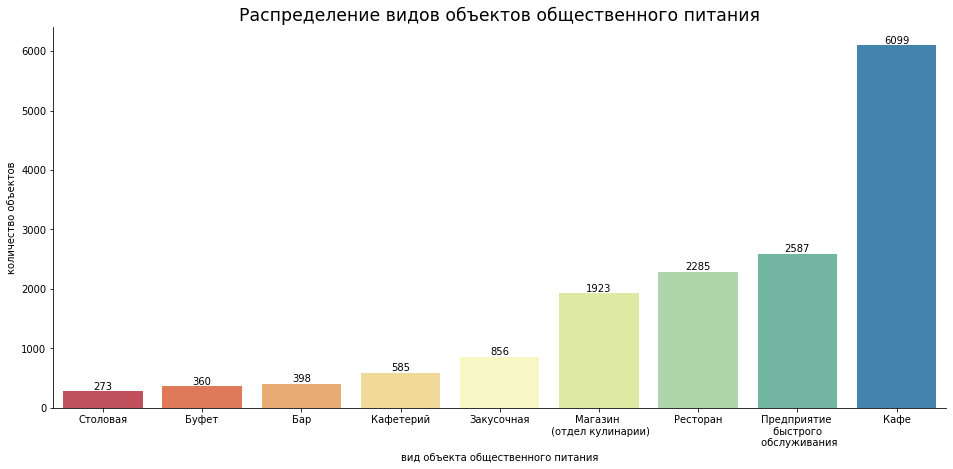

In [22]:
# сгруппируем данные для визуализации по виду объекта 
df_types = df.groupby(['object_type']).agg({'id': 'count'}).sort_values(by = 'id').reset_index()

# построим график
fig = plt.figure(figsize=(16, 7))
fig = sns.barplot(x='object_type', y='id',data = df_types,  palette='Spectral')
# создадим подписи
for i, val in enumerate(df_types['id'].values):
        plt.text(i, val, int(val), horizontalalignment='center', 
                 verticalalignment='bottom', fontdict={'fontweight':500, 'size':10})
plt.xticks(np.arange(9),
    ('Столовая','Буфет','Бар','Кафетерий','Закусочная','Магазин \n (отдел кулинарии)','Ресторан',
                  'Предприятие \n быстрого \n обслуживания','Кафе'))
plt.xlabel('вид объекта общественного питания')
plt.ylabel('количество объектов')
plt.title('Распределение видов объектов общественного питания', size = 'xx-large')
sns.despine() 
# plt.savefig('1.png')
# plt.close()

Кафе более чем в два раза популярнее ресторанов и предприятий быстрого обслуживания. Количество баров в Москве не превышает 3% от всего количества заведений. Столовые имеют самое маленькое количество заведений. 

### Исследование соотношения сетевых и несетевых заведений по количеству.

Необходимо исследовать соотношение сетевых и несетевых заведений и построить график.

Text(0.5, 1.0, 'График соотношения сетевых и не сетевых объектов общественного питания')

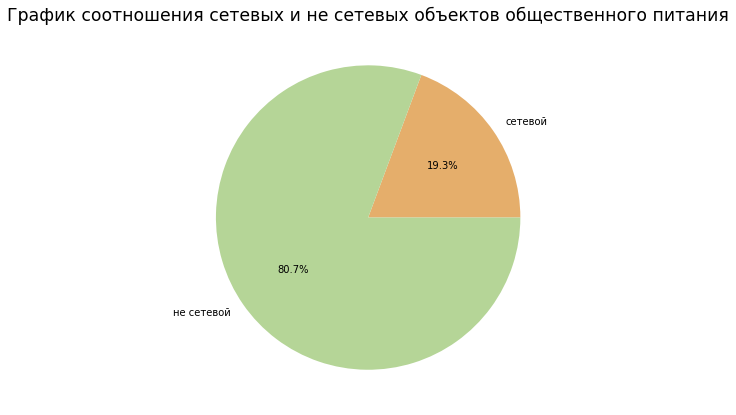

In [23]:
# сгруппируем данные для визуализации по признаку сети
df_chain = df.groupby(['chain']).agg({'id': 'count'}).sort_values(by = 'id').reset_index()

# назначим цвета для сетевого и несетевого вида объектов
colors = ['#e5ae6b', '#b5d597']
# построим график
plt.figure(figsize=(16, 7))
plt.pie(df_chain ['id'],labels=df_chain ['chain'],autopct='%1.1f%%', colors=colors)
plt.title('График соотношения сетевых и не сетевых объектов общественного питания', size = 'xx-large')
# plt.savefig('2.png')
# plt.close()

По соотношению видно, что 80,7% от всех заведений занимают не сетевые заведения.

### Исследование соотношения сетевых и несетевых заведений в разрезе видов объектов.

Исследуем для какого вида объекта общественного питания характерно сетевое распространение.

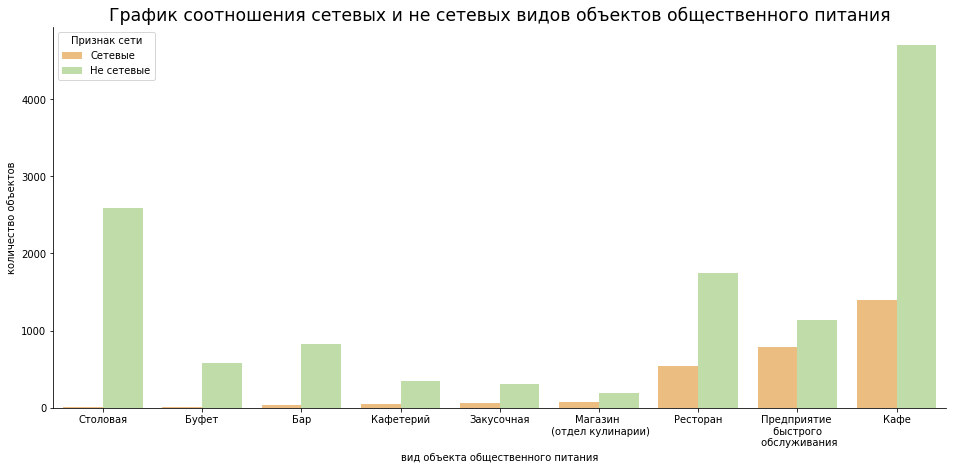

In [24]:
# сгруппируем данные для визуализации по виду объекта и признаку сети
df_types_chain = df.groupby(['object_type', 'chain']).agg({'id': 'count'}).sort_values(by = 'id').reset_index()

# построим график
fig = plt.figure(figsize=(16, 7))
fig = sns.barplot(x='object_type', y='id', hue='chain',data = df_types_chain, palette='Spectral')
plt.xticks(np.arange(9),
    ('Столовая','Буфет','Бар','Кафетерий','Закусочная','Магазин \n (отдел кулинарии)','Ресторан',
                  'Предприятие \n быстрого \n обслуживания','Кафе'))
plt.xlabel('вид объекта общественного питания')
plt.ylabel('количество объектов')
plt.title('График соотношения сетевых и не сетевых видов объектов общественного питания', size = 'xx-large')
h, l = fig.get_legend_handles_labels()
fig.legend(h,['Сетевые', 'Не сетевые'],title='Признак сети')
sns.despine() 
# plt.savefig('3.png')
# plt.close()

Сетевыми как правило бывают кафе, предприятия быстрого обслуживания и рестораны. Небольшая доля кулинарий, закусочных и кафетериев относятся к сетевым. Реже можно встретить сетевой бар или столовую.

### Исследование характеристики сетевых заведений.

Исследуем что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

count    2751.000000
mean       57.094148
std        57.308627
min         0.000000
25%        20.000000
50%        41.000000
75%        80.000000
max       580.000000
Name: number, dtype: float64


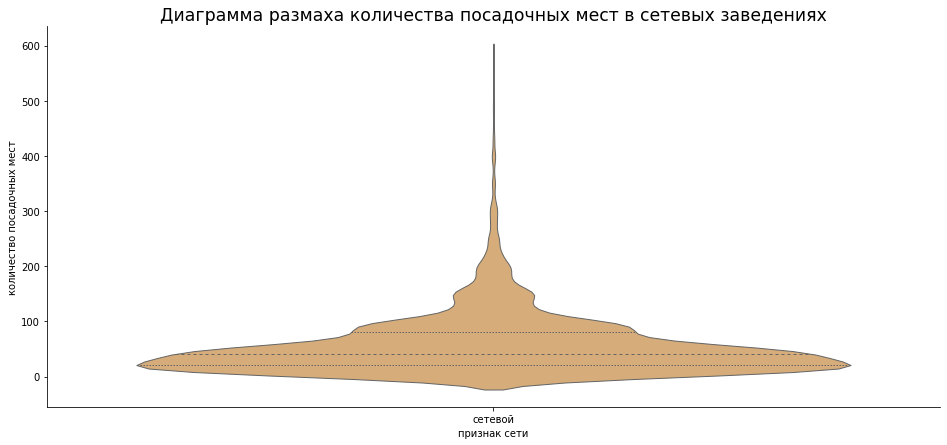

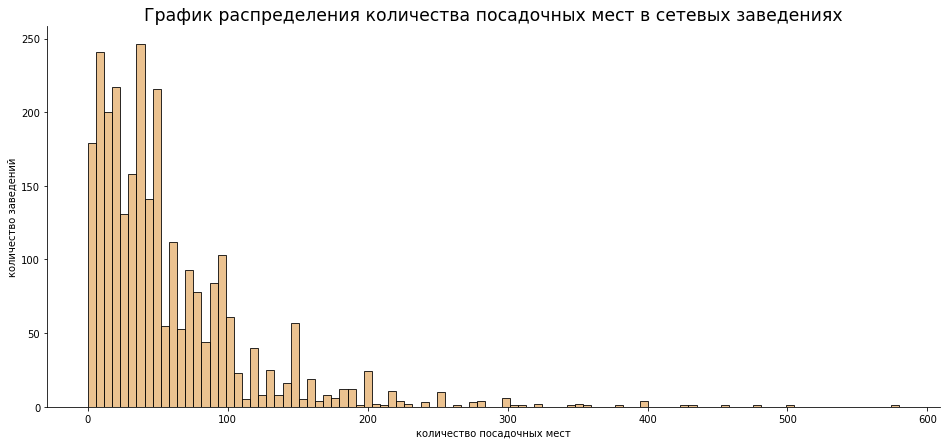

In [25]:
# создадим выборку сетевых объектов
df_chain = df.loc[(df['chain'] == 'сетевой')]
# посмотрим на качественные показатели 
print(df_chain['number'].describe())
# построим диаграмму размаха
plt.figure(figsize=(16, 7))
sns.violinplot(data=df_chain, x='chain', y='number', split=True, inner='quart', linewidth=1, color='#e5ae6b')
plt.title('Диаграмма размаха количества посадочных мест в сетевых заведениях', size = 'xx-large')
plt.xlabel('признак сети')
plt.ylabel('количество посадочных мест')
sns.despine()
# plt.savefig('4.png')
# plt.close()
# построим график распределения
plt.figure(figsize=(16, 7))
sns.histplot(data=df_chain, x='number', bins=100, color='#e5ae6b')
plt.title('График распределения количества посадочных мест в сетевых заведениях', size = 'xx-large')
plt.xlabel('количество посадочных мест')
plt.ylabel('количество заведений')
sns.despine()
# plt.savefig('5.png')
# plt.close()

count    11328.000000
mean        66.908192
std         79.504181
min          0.000000
25%         20.000000
50%         40.000000
75%         86.000000
max       1700.000000
Name: number, dtype: float64


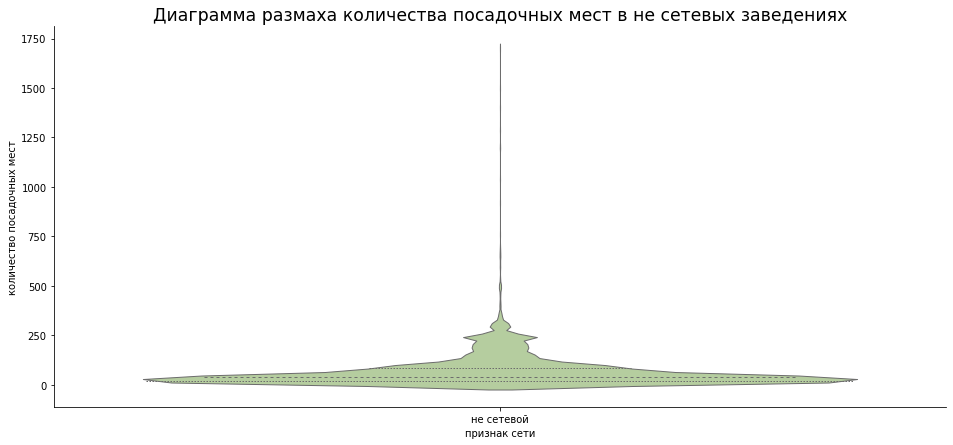

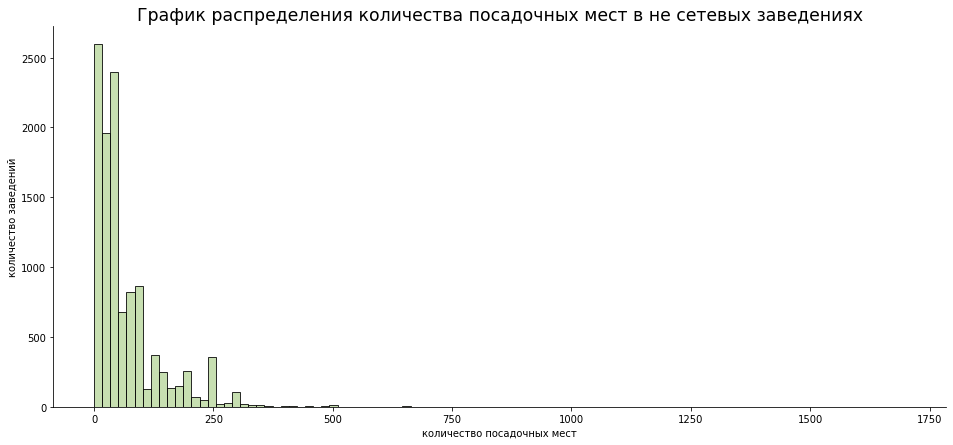

In [26]:
# создадим выборку не сетевых объектов
df_not_chain = df.loc[(df['chain'] != 'сетевой')]
# посмотрим на качественные показатели 
print(df_not_chain['number'].describe())
# построим диаграмму размаха
plt.figure(figsize=(16, 7))
sns.violinplot(data=df_not_chain, x='chain', y='number', split=True, inner='quart', linewidth=1, color='#b5d597')
plt.title('Диаграмма размаха количества посадочных мест в не сетевых заведениях', size = 'xx-large')
plt.xlabel('признак сети')
plt.ylabel('количество посадочных мест')
sns.despine()
# plt.savefig('6.png')
# plt.close()
# построим график распределения
plt.figure(figsize=(16, 7))
sns.histplot(data=df_not_chain, x='number', bins=100, color='#b5d597')
plt.title('График распределения количества посадочных мест в не сетевых заведениях', size = 'xx-large')
plt.xlabel('количество посадочных мест')
plt.ylabel('количество заведений')
sns.despine()
# plt.savefig('7.png')
# plt.close()

Три четверти сетевых объектов общественного питания имеет до 80 посадочных мест, что говорит о том, что сетевые объекты как правило не имеют гигантских размеров и вместимости. Максимальный размер вместимости сетевого объекта равен 580 посадочных мест. В сравнении с распределением количества посадочных мест с не сетевыми объектами в сетевых меньше объектов с нулевыми посадочными местами - закусочных и магазинов (отдел кулинарии).

### Исследование видов объектов общественного питания.

Изучим среднее количество посадочных мест для каждого вида объекта общественного питания. Посмотрим какой вид предоставляет в среднем самое большое количество посадочных мест.

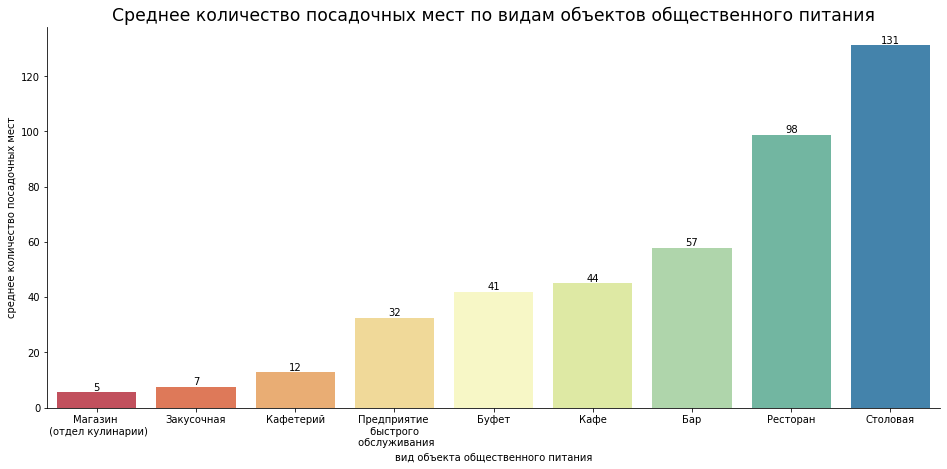

In [27]:
# сгруппируем среднее количество посадочных мест относительно вида объекта
df_types_mean = df.groupby(['object_type']).agg({'number': 'mean'}).sort_values(by = 'number').reset_index()
# построим график
fig = plt.figure(figsize=(16, 7))
fig = sns.barplot(x='object_type', y='number',data = df_types_mean,  palette='Spectral')
for i, val in enumerate(df_types_mean['number'].values):
        plt.text(i, val, int(val), horizontalalignment='center', 
                 verticalalignment='bottom', fontdict={'fontweight':500, 'size':10})
plt.xticks(np.arange(9),
    ('Магазин \n (отдел кулинарии)', 'Закусочная', 'Кафетерий', 'Предприятие \n быстрого \n обслуживания',
       'Буфет','Кафе', 'Бар','Ресторан','Столовая'))
plt.xlabel('вид объекта общественного питания')
plt.ylabel('среднее количество посадочных мест')
plt.title('Среднее количество посадочных мест по видам объектов общественного питания', size = 'xx-large')
sns.despine()
# plt.savefig('8.png')
# plt.close()

Столовые как правило располагают наибольшим количеством посадочных мест - в среднем 131 место. Самым маленьким количеством мест располагают закусочные и магазины(отделы кулинарии) - как мы выяснили большинство из них вообще не имеют посадочных мест. В баре в среднем могут поместиться 57 человек.

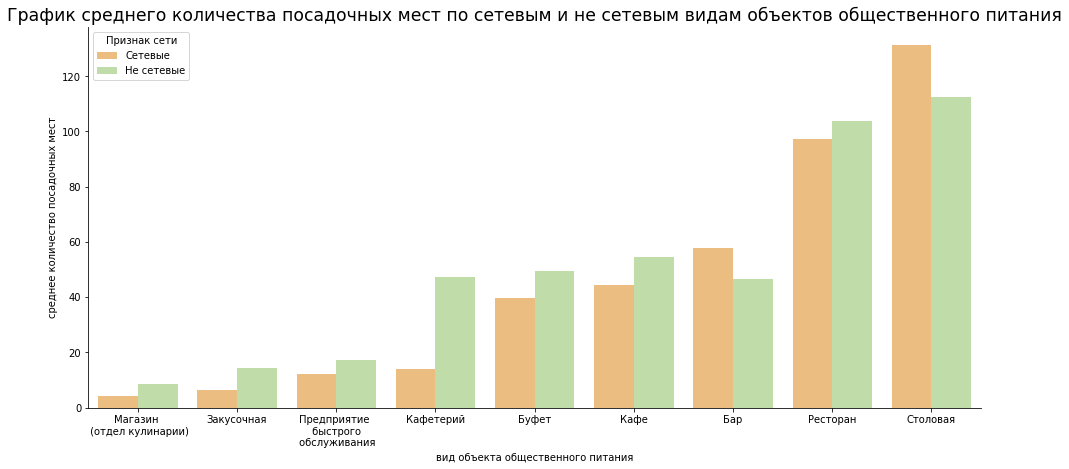

In [28]:
# сгруппируем среднее количество посадочных мест относительно вида объекта и принадлежности к сети
df_types_mean = df.groupby(['object_type', 'chain']).agg({'number': 'mean'}).sort_values(by = 'number').reset_index()
# построим график
fig = plt.figure(figsize=(16, 7))
fig = sns.barplot(x='object_type', y='number', hue='chain',data = df_types_mean, palette='Spectral')
plt.xticks(np.arange(9),
    ('Магазин \n (отдел кулинарии)', 'Закусочная', 'Предприятие \n быстрого \n обслуживания', 'Кафетерий',
       'Буфет','Кафе', 'Бар','Ресторан','Столовая'))
plt.xlabel('вид объекта общественного питания')
plt.ylabel('среднее количество посадочных мест')
plt.title('График среднего количества посадочных мест по сетевым и не сетевым видам объектов общественного питания', size = 'xx-large')

h, l = fig.get_legend_handles_labels()
fig.legend(h,['Сетевые', 'Не сетевые'],title='Признак сети')
sns.despine()
# plt.savefig('9.png')
# plt.close()

Как правило сетевые столовые имеют немного большее количество мест относительно не сетевых, также как и бары. Однако остальные виды объектов располагают большим количетсвом посадочных мест, если они не относятся к сети. Так что если большая компания хочет идти в кафе или ресторан, то лучше предпочесть не сетевой ресторан.

### Выделение в отдельный столбец информации об улице из столбца address .

Для этого нам необходимо написать фукцию, которая по условиям будет выделять и записывать название улиц/проспектов/бульваров и тд.

In [29]:
# создадим функцию для выделения улиц
def get_street (df):
    full_address = df['address']
    i = full_address.count(',')
    for j in range(i):
        if "улица" in full_address.split(', ')[j]:
            return (full_address.split(', ')[j])
        if "проспект" in full_address.split(', ')[j]:
            return (full_address.split(', ')[j])
        if "переулок" in full_address.split(', ')[j]:
            return (full_address.split(', ')[j])
        if "шоссе" in full_address.split(', ')[j]:
            return (full_address.split(', ')[j])
        if "бульвар" in full_address.split(', ')[j]:
            return (full_address.split(', ')[j])
# применим функцию       
df['street'] =df.apply(get_street, axis=1)
# отобразим полученные данные
display(df)

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,не сетевой,кафе,"город Москва, улица Егора Абакумова, дом 9",48.0,улица Егора Абакумова
1,77874,Родник,не сетевой,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35.0,улица Талалихина
2,24309,Кафе «Академия»,не сетевой,кафе,"город Москва, Абельмановская улица, дом 6",95.0,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,сетевой,кафе,"город Москва, Абрамцевская улица, дом 1",40.0,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,не сетевой,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50.0,Абрамцевская улица
...,...,...,...,...,...,...,...
15361,208537,Шоколадница,сетевой,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50.0,3-й Крутицкий переулок
15362,209264,Шоколадница,сетевой,кафе,"город Москва, улица Земляной Вал, дом 33",10.0,улица Земляной Вал
15363,209186,Шоколадница,сетевой,кафе,"город Москва, улица Земляной Вал, дом 33",20.0,улица Земляной Вал
15364,221900,Шоколадница,сетевой,кафе,"город Москва, поселение Московский, Киевское шоссе, 22-й километр, домовладение 4, строение 1",36.0,Киевское шоссе


Для каждого адреса мы выделили улицу. Также на этом этапе мы обогатим основной датафрейм данными из внешних источников - координаты и районы. Для этого смерджим таблицы.

In [30]:
# смерджим таблицы
df_new = df.merge(df_geo, on='address', how='left')
df_new = df_new.merge(df_outer, on='street', how='left')
# отобразим полученные данные
df_new

,id,object_name,chain,object_type,address,number,street,lat,lon,area
0,151635,СМЕТАНА,не сетевой,кафе,"город Москва, улица Егора Абакумова, дом 9",48.0,улица Егора Абакумова,55.87903,37.71453,Ярославский Район
1,77874,Родник,не сетевой,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35.0,улица Талалихина,55.50732,37.57944,Таганский район
2,77874,Родник,не сетевой,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35.0,улица Талалихина,55.50732,37.57944,Нижегородский район
3,77874,Родник,не сетевой,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35.0,улица Талалихина,55.50732,37.57944,Район Южное Бутово
4,24309,Кафе «Академия»,не сетевой,кафе,"город Москва, Абельмановская улица, дом 6",95.0,Абельмановская улица,55.73558,37.66959,Таганский район
...,...,...,...,...,...,...,...,...,...,...
29911,209264,Шоколадница,сетевой,кафе,"город Москва, улица Земляной Вал, дом 33",10.0,улица Земляной Вал,55.75721,37.65909,Басманный район
29912,209186,Шоколадница,сетевой,кафе,"город Москва, улица Земляной Вал, дом 33",20.0,улица Земляной Вал,55.75721,37.65909,Таганский район
29913,209186,Шоколадница,сетевой,кафе,"город Москва, улица Земляной Вал, дом 33",20.0,улица Земляной Вал,55.75721,37.65909,Басманный район
29914,221900,Шоколадница,сетевой,кафе,"город Москва, поселение Московский, Киевское шоссе, 22-й километр, домовладение 4, строение 1",36.0,Киевское шоссе,55.62311,37.40766,Район Внуково


Данные успешно соединились.

### Выделение топ-10 улиц по количеству объектов общественного питания.

Найдем топ-10 улиц по количеству объектов общественного питания и отобразим на графике. Посмотрим в каких районах Москвы находятся эти улицы. Для начала отобразим на карте все объекты общественного питания относительно их сетевой принадлежности и посмотрим на скопление.

In [31]:
# отберем нужные данные для визуализации 
df_new_viz = df_new[['object_name','street','chain', 'area', 'lat', 'lon']]
# df_new_viz.head()

In [32]:
# сформируем конфигурацию для отображения
config = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [],
      "layers": [
        {
          "id": "vmy03h8",
          "type": "point",
          "config": {
            "dataId": "unnamed",
            "label": "Признак сети",
            "color": [
              18,
              92,
              119
            ],
            "columns": {
              "lat": "lat",
              "lng": "lon",
              "altitude": None
            },
            "isVisible": True,
            "visConfig": {
              "radius": 10,
              "fixedRadius": False,
              "opacity": 0.6,
              "outline": False,
              "thickness": 2,
              "strokeColor": None,
              "colorRange": {
                "name": "ColorBrewer Set2-4",
                "type": "qualitative",
                "category": "ColorBrewer",
                "colors": [
                  "#66c2a5",
                  "#fc8d62",
                  "#8da0cb",
                  "#e78ac3"
                ]
              },
              "strokeColorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "radiusRange": [
                0,
                50
              ],
              "filled": True
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": {
              "name": "chain",
              "type": "string"
            },
            "colorScale": "ordinal",
            "strokeColorField": None,
            "strokeColorScale": "quantile",
            "sizeField": None,
            "sizeScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "unnamed": [
              {
                "name": "object_name",
                "format": None
              },
              {
                "name": "street",
                "format": None
              },
              {
                "name": "chain",
                "format": None
              },
              {
                "name": "area",
                "format": None
              }
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 0,
      "dragRotate": False,
      "latitude": 55.71932152085772,
      "longitude": 37.62615254390752,
      "pitch": 0,
      "zoom": 9.46946800571445,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "light",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        218.82023004728686,
        223.47597962276103,
        223.47597962276103
      ],
      "mapStyles": {}
    }
  }
}

In [33]:
# создадим пустую карту с нашей конфигурацией
kepler_map = keplergl.KeplerGl(height=600, config = config)
# присоединим данные на карту
kepler_map.add_data(data=df_new_viz)
# выведем карту (раскомментить для вывода)
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'vmy03h8', 'type': …

Объекты общественного питания распределены достаточно равномерно, однако их наибольшая концентрация отмечена ближе к центру. Также можно наглядно увидеть, что не сетевых объектов намного больше, чем сетевых. Выясним на каких улицах находится большое количество объектов и визуально оценим районы их расположения.

In [34]:
# выберем пот-10 улиц с помощью сводной таблицы
top_10_streets = df.pivot_table(index='street', aggfunc={'id' : 'count', 'number' : 'mean'}).sort_values(by=['id'], ascending=False).head(10)
# добавим данные для визуализации
top_10 = top_10_streets.merge(df_new, on='street', how='left')
# отберем данные для визуализации
top_10_streets = top_10[['street', 'id_x', 'area', 'lat', 'lon']]
# соберем датафрейм из топ-10 улиц
streets = top_10_streets['street'].unique()
df_10 = df.query('street in @streets')    
print('\nколичество заведений на улицах', top_10_streets['id_x'].unique().sum())
print('\nколичество районов для топа 10 улиц', top_10_streets['area'].nunique(), 'районов')
# print('\nРАЙОНЫ ТОП 10 УЛИЦ')
# areas = top_10_streets['area'].unique()
# for area in areas:
#     print(area)  


количество заведений на улицах 1443

количество районов для топа 10 улиц 36 районов


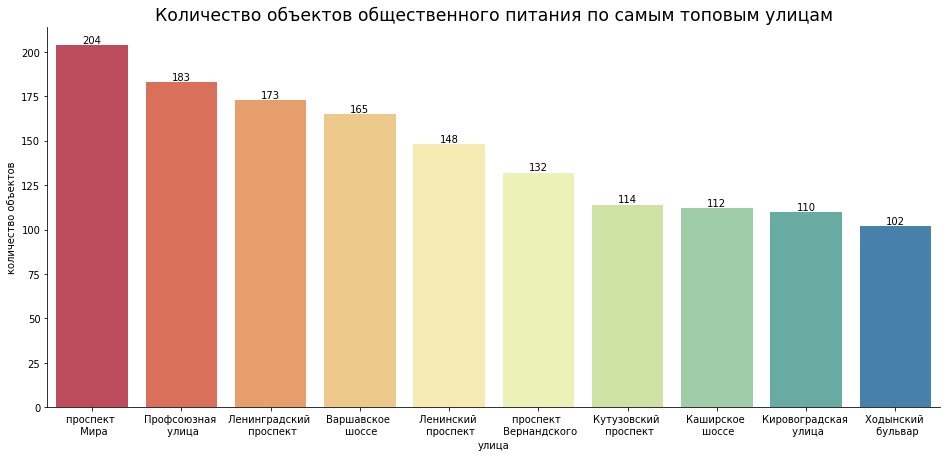

In [35]:
# сгруппируем количество объектов относительно топ-10 улиц
df_10_viz = df_10.groupby(['street']).agg({'id': 'count'}).sort_values(by = 'id',ascending=False).reset_index()

# построим график
fig = plt.figure(figsize=(16, 7))
fig = sns.barplot(x='street', y='id',data = df_10_viz,  palette='Spectral')
for i, val in enumerate(df_10_viz['id'].values):
        plt.text(i, val, int(val), horizontalalignment='center', 
                 verticalalignment='bottom', fontdict={'fontweight':500, 'size':10})
plt.xlabel('улица')
plt.ylabel('количество объектов')
plt.title('Количество объектов общественного питания по самым топовым улицам', size = 'xx-large')
plt.xticks(np.arange(10),
    ('проспект \n Мира', 'Профсоюзная \n улица', 'Ленинградский \n проспект', 'Варшавское \n шоссе', 'Ленинский \n проспект', 
       'проспект \n Вернандского','Кутузовский \n проспект', 'Каширское \n шоссе','Кировоградская \n улица','Ходынский \n бульвар'))
sns.despine() 
# plt.savefig('10.png')
# plt.close()

На проспекте Мира расположено в два раза больше объектов общественного питания, чем на Ходынском бульваре. 

In [36]:
# отберем нужные данные для визуализации 
df_viz = top_10_streets[['street', 'area', 'lat', 'lon']]
# df_viz.head()

In [37]:
# сформируем конфигурацию для отображения
config = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [],
      "layers": [
        {
          "id": "6wir6r6",
          "type": "hexagon",
          "config": {
            "dataId": "unnamed",
            "label": "Район",
            "color": [
              255,
              153,
              31
            ],
            "columns": {
              "lat": "lat",
              "lng": "lon"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.51,
              "worldUnitSize": 1,
              "resolution": 8,
              "colorRange": {
                "name": "ColorBrewer RdYlGn-10",
                "type": "diverging",
                "category": "ColorBrewer",
                "colors": [
                  "#a50026",
                  "#d73027",
                  "#f46d43",
                  "#fdae61",
                  "#fee08b",
                  "#d9ef8b",
                  "#a6d96a",
                  "#66bd63",
                  "#1a9850",
                  "#006837"
                ]
              },
              "coverage": 1,
              "sizeRange": [
                0,
                500
              ],
              "percentile": [
                0,
                100
              ],
              "elevationPercentile": [
                0,
                100
              ],
              "elevationScale": 5,
              "colorAggregation": "mode",
              "sizeAggregation": "count",
              "enable3d": False
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": {
              "name": "area",
              "type": "string"
            },
            "colorScale": "ordinal",
            "sizeField": None,
            "sizeScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "unnamed": [
              {
                "name": "street",
                "format": None
              },
              {
                "name": "area",
                "format": None
              }
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 0,
      "dragRotate": False,
      "latitude": 55.6939675209769,
      "longitude": 37.614262012380536,
      "pitch": 0,
      "zoom": 9.422888637718028,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "light",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

In [38]:
# создадим пустую карту с нашей конфигурацией
kepler_map = keplergl.KeplerGl(height=600, config=config)
# присоединим данные к карте
kepler_map.add_data(data=df_viz)
# выведем карту (раскомментить для вывода)
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '6wir6r6', 'type': …

В Академическом и Алексеевском районах Москвы сосредоточено наибольшее количество улиц с нибольшим количеством объектов общественного питания. Гуляя по этим районам вы точно не останетесь без еды.

### Выделение улиц с одним объектом общественного питания. 

Найдем улицы по с одним объектом общественного питания и отобразим их на графике. Посмотрим в каких районах Москвы они находятся.

In [39]:
# сргуппируем количество объектов по улице и району 
last_10_streets = df_new.groupby(['street', 'area']).agg({'id': 'count'}).sort_values(by = 'id', ascending=False).reset_index()
# отберем улицы с одним объектом 
last_10_streets = last_10_streets.loc[last_10_streets['id'] == 1]
# добавим данные для визуализации
last_10_streets = last_10_streets.merge(df_new, on='street', how='left')

print('\nколичество улиц с одним объектом', last_10_streets['street'].nunique(), 'улиц')
print('\nколичество районов для улиц с одним объектом', last_10_streets['area_x'].nunique(), 'районов')
# подготовим данные для визуализации
df_viz2 = last_10_streets[['street', 'id_x', 'area_y', 'lat', 'lon']]


количество улиц с одним объектом 400 улиц

количество районов для улиц с одним объектом 95 районов


In [40]:
# сформируем конфигурацию для отображения
config1 = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [],
      "layers": [
        {
          "id": "tku0yvi",
          "type": "cluster",
          "config": {
            "dataId": "unnamed",
            "label": "Районы",
            "color": [
              255,
              153,
              31
            ],
            "columns": {
              "lat": "lat",
              "lng": "lon"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.38,
              "clusterRadius": 40,
              "colorRange": {
                "name": "ColorBrewer RdYlGn-11",
                "type": "diverging",
                "category": "ColorBrewer",
                "colors": [
                  "#a50026",
                  "#d73027",
                  "#f46d43",
                  "#fdae61",
                  "#fee08b",
                  "#ffffbf",
                  "#d9ef8b",
                  "#a6d96a",
                  "#66bd63",
                  "#1a9850",
                  "#006837"
                ]
              },
              "radiusRange": [
                0,
                50
              ],
              "colorAggregation": "mode"
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": {
              "name": "area_y",
              "type": "string"
            },
            "colorScale": "ordinal"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "unnamed": [
              {
                "name": "street",
                "format": None
              }
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 0,
      "dragRotate": False,
      "latitude": 55.7413918471803,
      "longitude": 37.571518454024286,
      "pitch": 0,
      "zoom": 10.106529301596298,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "light",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

In [41]:
# создадим пустую карту с нашей конфигурацией
kepler_map = keplergl.KeplerGl(height=600,config = config1)
# добавим данные к карте
kepler_map.add_data(data=df_viz2)
# выведем карту (раскомментить для вывода)
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'tku0yvi', 'type': …

На 400 улицах Москвы находится только один объект общественного питания. В Басманном, Тверском и Хамовниках гуляя по улицам нужно будет долго идти в поисках разнообразных заведений общественного питания.

### Исследование распределения посадочных мест для улиц с большим количеством объектов общественного питания.

Изучим распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.

count    1256.000000
mean       65.039013
std        93.725322
min         0.000000
25%        20.000000
50%        40.000000
75%        80.000000
max      1700.000000
Name: number, dtype: float64


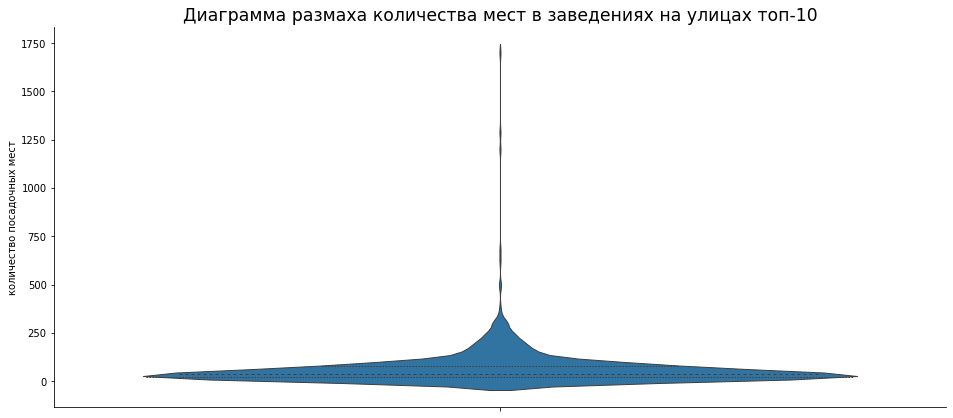

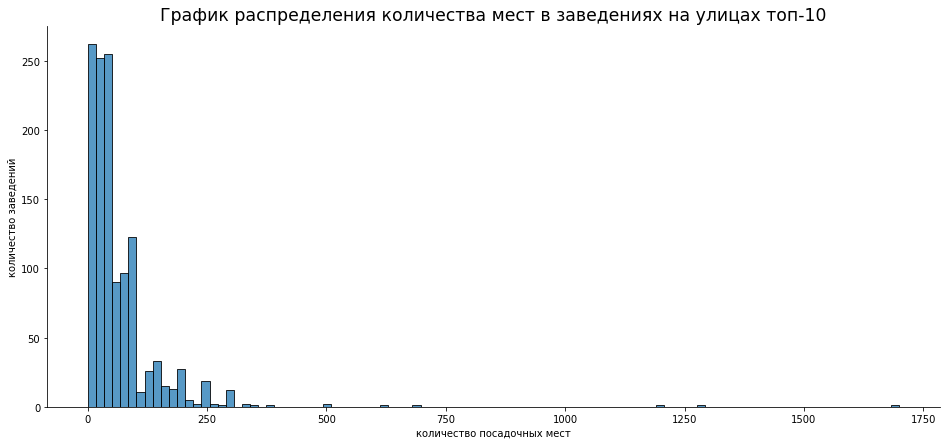

In [42]:
# посмотрим количественные показатели количества посадочных мест на топ-10 улиц 
print(df_10['number'].describe())
# построим диграмму размаха
plt.figure(figsize=(16, 7))
sns.violinplot(data=df_10, y="number",
               split=True, inner="quart", linewidth=1)
plt.title('Диаграмма размаха количества мест в заведениях на улицах топ-10', size = 'xx-large')
plt.ylabel('количество посадочных мест')
sns.despine()
# plt.savefig('11.png')
# plt.close()
# построим график распределения
plt.figure(figsize=(16, 7))
sns.histplot(data=df_10, x='number', bins=100,  palette='Spectral')
plt.title('График распределения количества мест в заведениях на улицах топ-10', size = 'xx-large')
plt.xlabel('количество посадочных мест')
plt.ylabel('количество заведений')
sns.despine()
# plt.savefig('12.png')
# plt.close()

Три четверти объектов, расположеных на улицах из топ-10 по количеству заведений, имеют до 80 посадочных мест. Также на этих улицах располагается самый крупный объект в городе - не сетевой бар "Arena by Soho Family" на Кутузовском проспекте на 1700 посадочных мест. Довольно много объектов с минимальным количеством посадочных мест - например закусочных и магазинов (отделов кулинарий).

### Общий вывод и рекомендации о виде заведения, количестве посадочных мест, а также районе расположения и возможности развития сети.

На основании исследования рынка общественного питания в Москве можно сказать, что:

- кафе более чем в два раза популярнее ресторанов и предприятий быстрого обслуживания;

- столовые мало распространены, но при этом имеют самую большую среднюю вместимость;

- только 19,3 % от всех заведений занимают сетевые и как правило это кафе, предприятия быстрого обслуживания или рестораны;

- 3/4 сетевых объектов общественного питания имеет средний размер - до 80 посадочных мест;

- объекты, не принадлежащие сети, располагают большим количеством посадочных мест. Так что если большая компания хочет идти в кафе или ресторан, то лучше предпочесть не сетевое заведение;

- В Басманном, Тверском и Хамовниках гуляя по улицам нужно будет долго идти в поисках разнообразных заведений общественного питания. В то время как Академическом и Алексеевском районах Москвы сосредоточено наибольшее количество улиц с нибольшим количеством объектов общественного питания. Гуляя по этим районам вы точно не останетесь без еды.;

**Для открытия новаторского объекта - такого как заведение с роботами необходимо:**

- остановиться на выборе вида заведения "**ресторан**", так как он имеет наибольшую популярность после столовых (а мы ведь явно не столовая);

- **со средним количеством посадочных мест - до 40**, так как новизна формата не позволяет делать слишком большие площади, но и минимальную вместимость тоже не целесообразно из-за ожидающегося потока посетителей;

- **в районе с наибольшей доступностью**. Предположительно это центральные улицы, даже при условии наибольшего количества конкурирующих заведений уникальность формата дает возможность предствалять альтернативу существующим заведениям.
- **с перспективой развития сети ресторанов.** Первый робо-ресторан станет местом опробации новых идей и решений, которые потом будут внедряться в остальные рестораны сети.

## Презентация исследования для инвесторов.

Презентация: https://disk.yandex.ru/i/ztQM4ZeIEJn0qw 